In [28]:
import typing

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_path = "../../datasets"
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # normalize by mean and standard deviation; values were determined on dataset
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_dataset = datasets.MNIST(
    data_path,
    train=True,
    download=True,
    transform=transform,
)

test_loader = DataLoader(
    datasets.MNIST(data_path, train=False, download=False, transform=transform),
    shuffle=False,
    drop_last=False,
    batch_size=10000,
    generator=torch.Generator(),
)

## sample dataset

In [29]:
from matplotlib import pyplot as plt
import math
from torch.utils.data import Dataset


def render_records(images: typing.Sequence[torch.Tensor], labels: typing.Sequence[str]):
    images_count = len(images)
    if images_count != len(labels):
        raise ValueError("dimensions of images and labels must match")

    axes_length = math.ceil(math.sqrt(images_count))
    fig, axes = plt.subplots(axes_length, axes_length, figsize=(10, 10))

    # loaded images are of shape C x W x H
    image_channels = images[0].shape[0]
    image_dimensions = (images[0].shape[1], images[0].shape[2])

    fig.suptitle(
        f"image of dimensions {image_dimensions} with {image_channels} channels"
    )

    for image, label, axis in zip(images, labels, axes.flatten()):
        # loaded images are of shape C x W x H, but axis.imshow expects channel to go last
        image = image.permute(1, 2, 0).cpu().numpy()

        axis.imshow(image, cmap="gray")
        axis.set_title(f"Label: {label}")
        axis.axis("off")

    for remaining_axis in axes.flatten()[images_count:]:
        # Releases viewport reserved by subplot, which allows matplotlib to omit empty rows.
        # fig.axis("off") would keep the space reserved, causing in an empty white row.
        fig.delaxes(remaining_axis)

    return fig


def render_random_records(
    n: int, dataset: Dataset[typing.Any], label_map: typing.Mapping[int, str]
):
    loader = DataLoader(dataset, batch_size=n, shuffle=True)
    sample_images, sample_labels = next(iter(loader))

    resolved_labels = [label_map[it.item()] for it in sample_labels]
    return render_records(sample_images, resolved_labels)

/var/folders/nm/sy1cwyln7zq5tvjz165flcmh0000gn/T/ipykernel_74025/2066043385.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ).show()


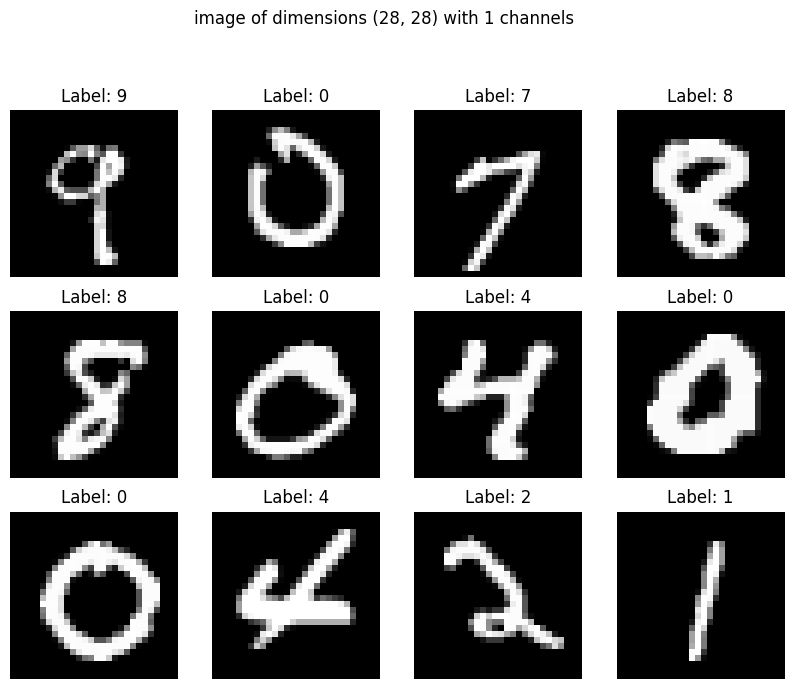

In [30]:
render_random_records(
    12,
    train_dataset,
    {it: str(it) for it in range(10)},
).show()

## determine class size / verify class balance

In [31]:
from collections import Counter


def count_distinct_values(targets: typing.Iterable[typing.Any]):
    targets_count = Counter(targets)

    for target, count in targets_count.items():
        print(f"Target {target}: {count} records")

    print(f"Total: {targets_count.total()}")

In [32]:
count_distinct_values(train_dataset.targets.numpy())

Target 5: 5421 records
Target 0: 5923 records
Target 4: 5842 records
Target 1: 6742 records
Target 9: 5949 records
Target 2: 5958 records
Target 3: 6131 records
Target 6: 5918 records
Target 7: 6265 records
Target 8: 5851 records
Total: 60000


## analyze how classes are split across partitions

In [33]:
from components.data_splitting import (
    index_by_approximate_binary_target_partitions,
    partition_dataset,
)

sample_index = index_by_approximate_binary_target_partitions(train_dataset, 10, 42)
subsets = partition_dataset(train_dataset, sample_index)

for subset_idx, subset in enumerate(subsets):
    print(f"==== subset #{subset_idx} ====")
    subset_targets = list(int(it) for _, it in DataLoader(subset))
    count_distinct_values(subset_targets)

==== subset #0 ====
Target 2: 3000 records
Target 7: 3000 records
Total: 6000
==== subset #1 ====
Target 3: 3000 records
Target 6: 2935 records
Target 7: 65 records
Total: 6000
==== subset #2 ====
Target 1: 3665 records
Target 2: 2335 records
Total: 6000
==== subset #3 ====
Target 2: 623 records
Target 3: 2377 records
Target 5: 17 records
Target 6: 2983 records
Total: 6000
==== subset #4 ====
Target 3: 754 records
Target 4: 2246 records
Target 0: 2923 records
Target 1: 77 records
Total: 6000
==== subset #5 ====
Target 8: 51 records
Target 9: 2949 records
Target 0: 3000 records
Total: 6000
==== subset #6 ====
Target 4: 596 records
Target 5: 2404 records
Target 7: 200 records
Target 8: 2800 records
Total: 6000
==== subset #7 ====
Target 5: 3000 records
Target 4: 3000 records
Total: 6000
==== subset #8 ====
Target 7: 3000 records
Target 8: 3000 records
Total: 6000
==== subset #9 ====
Target 9: 3000 records
Target 1: 3000 records
Total: 6000
